In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../src"))
from utils import *

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Creating a simple dataset using the linear regression formula

We'll use a linear regression to make a straight line with known parameters and see if the neural network can learn these parameters

In [3]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #Needed for modelling
y = weight * X  + bias
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

## 2. Train-test split

In [4]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

## 3. Visualize data

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """Plots training data, test data and compares predictions

    Args:
        train_data (_type_, optional): _description_. Defaults to X_train.
        train_labels (_type_, optional): _description_. Defaults to y_train.
        test_data (_type_, optional): _description_. Defaults to X_test.
        test_labels (_type_, optional): _description_. Defaults to y_test.
        predictions (_type_, optional): _description_. Defaults to None.
    """
    
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b",s=4,
                label = "Training data")
    plt.scatter(test_data, test_labels, c="r", s=4, label="Testing data")
    plt.ylabel('y')
    plt.xlabel('X')
    if predictions:
        plt.scatter(test_data, predictions, c = "k", s=4, label="predictions")

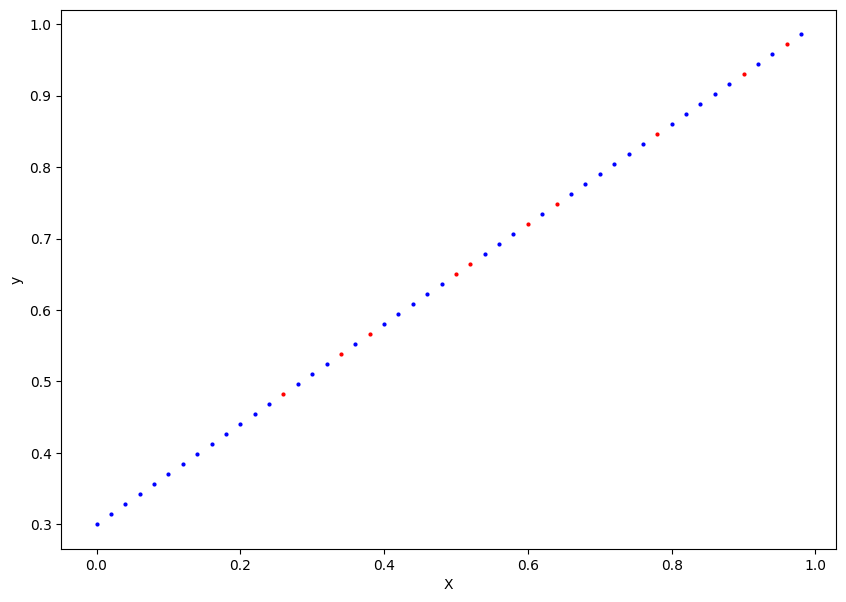

In [6]:
plot_predictions()

## 3. Creating our first PyTorch Model for Linear Regression
The weights and bias are randomly initialized and updated with each epoch.

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.weights * X + self.bias

In [8]:
device = get_device()
model = LinearRegressionModel()
device, model

('mps', LinearRegressionModel())